Creating an automatic AMIA-based forecast for the data set of montly UW-Madison employee counts I developed before using a different package

In [1]:
# import packages that will be used in this example 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects as robjects # R process interface
from rpy2.robjects.packages import importr  # R package importer
from rpy2.robjects import pandas2ri # pandas conversion engine

import sys # System-specific parameters and functions 
import importlib # Implementation of python "import" statement 
import os
import ctedefs # another python file imported as module 
import datetime as dt # Date/Time functions
from pathlib import Path # directory path manipulation
from sqlalchemy import create_engine # RDBMS integration w/ Pandas

In [2]:
# Pull value of USERPROFILE form environment variables
userprofile_dir = Path(os.environ['USERPROFILE'])  
# Dynamically load $USERPROFILE/connection.py
connection_module = 'connection'
sys.path.append(str(userprofile_dir))
connection = importlib.import_module(connection_module)
sys.path.remove(str(userprofile_dir))

In [3]:
# Connect to EPM
# The call to connection.epm() to build connection string
engine = create_engine(connection.epm())
con = engine.connect()

In [4]:
# Run a test query - experiment with try/except around database calls
try:
  df_test = pd.read_sql('select 1 as cnt from dual', con)
except:
  print('EPM Connection Test exception')
  raise # reraise the exception - this will stop execution with a stack trace
else:
  if (df_test['cnt'][0] == 1):
    result = 'success'
  else:
    result = 'failure'
  print('EPM Connection Test: ' + result) # iterate through the past 12 months 

EPM Connection Test: success


In [5]:
cumulativeDf = pd.DataFrame() 

# *** SOLUTION to create a time series in python 
end_dt = pd.Timestamp(dt.datetime.now())   # current timestamp
end_dt = end_dt.replace(day=1,hour=0,minute=0,second=0,microsecond=0)  # midnight first day of current month
offset = -99    # number of previous time periods - note the negative sign for going back in time

# current time offset months previous
start_dt = (pd.Timestamp(dt.datetime.now()) + pd.DateOffset(months=offset))   
# midnight of first day of offset months previous
start_dt = start_dt.replace(day=1,hour=0,minute=0,second=0,microsecond=0)   
# create a list of month start dates, values for freq= are in pandas documentation
dateList = pd.date_range(start=start_dt, end=end_dt, freq='MS')    

# convert the timestamp series to string format series 
dateList = dateList.astype(str)

for date in dateList:
        numEmplDf = pd.read_sql(ctedefs.active_empl_cte.query_full().replace("CURRENT_DATE", date), con)
        cumulativeDf = cumulativeDf.append(numEmplDf)

In [6]:
cumulativeDf

monthdate  numofempl
0   2011-03-01      39335
0   2011-04-01      39820
0   2011-05-01      40094
0   2011-06-01      38594
0   2011-07-01      38710
0   2011-08-01      38477
0   2011-09-01      40184
0   2011-10-01      40983
0   2011-11-01      41352
0   2011-12-01      41435
0   2012-01-01      40684
0   2012-02-01      40396
0   2012-03-01      40686
0   2012-04-01      40753
0   2012-05-01      40815
0   2012-06-01      38347
0   2012-07-01      38383
0   2012-08-01      38140
0   2012-09-01      39796
0   2012-10-01      40696
0   2012-11-01      40804
0   2012-12-01      40663
0   2013-01-01      39882
0   2013-02-01      40172
0   2013-03-01      40447
0   2013-04-01      40491
0   2013-05-01      40608
0   2013-06-01      38333
0   2013-07-01      38328
0   2013-08-01      37852
..         ...        ...
0   2017-01-01      38353
0   2017-02-01      39115
0   2017-03-01      39427
0   2017-04-01      39584
0   2017-05-01      39733
0   2017-06-01      37801
0   2017-07-01      37984
0   2017-08-01      37824
0   2017-09-01      38579
0   2017-10-01      39535
0   2017-11-01      39843
0   2017-12-01      40032
0   2018-01-01      39075
0   2018-02-01      39752
0   2018-03-01      40183
0   2018-04-01      40378
0   2018-05-01      40564
0   2018-06-01      38442
0   2018-07-01      38949
0   2018-08-01      38670
0   2018-09-01      39499
0   2018-10-01      40244
0   2018-11-01      40553
0   2018-12-01      40614
0   2019-01-01      39736
0   2019-02-01      40468
0   2019-03-01      40984
0   2019-04-01      41054
0   2019-05-01      41187
0   2019-06-01      39781

[100 rows x 2 columns]

In [7]:
cumulativeDf.index = pd.to_datetime(cumulativeDf["monthdate"])
cumulativeDf.drop(['monthdate'], axis=1, inplace=True)

In [8]:
# Extract the year, month, day for the beginning of the series into a numpy array 
start_time_ary = np.array([cumulativeDf.index[0].year, cumulativeDf.index[0].month, cumulativeDf.index[0].day])

In [10]:
# start the pandas conversion engine 
pandas2ri.activate()

ts = robjects.r('ts') # handle to R ts() function 
forecast = importr('forecast') # handle to R forecast package 

In [11]:
# Call R ts() to build the time series structure and return an rpy2 ahndle to it 
rdata = ts(cumulativeDf.numofempl.values, start = start_time_ary, frequency = 12)

# Call R auto_arima() to grid search ARIMA models and find the "best" fit 
# Return an rpy2 handle to the model 
fit = forecast.auto_arima(rdata) # handle to R arima model 

In [12]:
# Call R forecast() to compute predicted values based on the model 
# Return an rpy2 handle to the forecast structure (not an R dataframe!)
# Predict 24 time peridos, monthly 
forecast_output = forecast.forecast(fit, h = 24, level = (95.0))

In [14]:
# Extract forecast_output components into a few Pandas series 
index = pd.date_range(start = cumulativeDf.index.max(), periods = len(forecast_output[3])+1, freq = 'M')[1:]
forecast = pd.Series(forecast_output[3], index=index)
lowerpi = pd.Series(forecast_output[4], index=index)
upperpi = pd.Series(forecast_output[5], index=index)

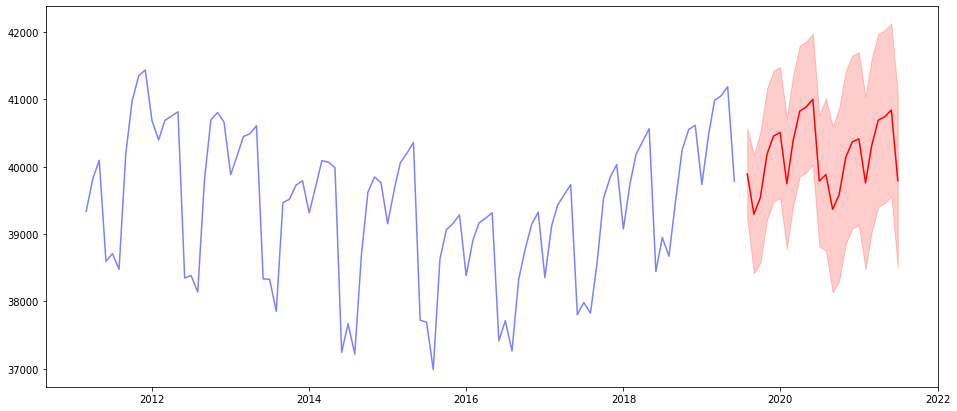

In [16]:
# Plot the series, mean forecast and 95tile prediction "cone"
fig = plt.figure(figsize=(16,7))
ax = plt.axes()
ax.plot(cumulativeDf.index, cumulativeDf.numofempl.values, color = 'blue', alpha = 0.5)
ax.plot(forecast.index, forecast.values, color = 'red')
ax.fill_between(forecast.index, lowerpi.values, upperpi.values, alpha = 0.2, color = 'red')

In [17]:
# R function that assembles the forecast() output into a proper dataframe 
rstring = '''
    function(testdata){
        library(forecast)
        fitted_model<-auto.arima(testdata)
        forecasted_data<-forecast(fitted_model,h=24,level=c(95))
        outdf<-data.frame(forecasted_data$mean, forecasted_data$lower, forecasted_data$upper)
        colnames(outdf)<-c('forecast','lower_95_pi', 'upper_95_pi')
        outdf
    }
'''
rfunc = robjects.r(rstring) # handle to the function 
# note: c(95) -- prediction interval 

In [18]:
rdata2 = ts(cumulativeDf.numofempl.values, start = start_time_ary, frequency = 12)
r_df = rfunc(rdata2)

In [19]:
# Convert the R forecast dataframe into a Pandas dataframe
forecast_df = pandas2ri.ri2py(r_df)
forecast_df.index = pd.date_range(start=cumulativeDf.index.max(), periods=len(forecast_df)+1, freq='M')[1:]

C:\Users\sliu\.conda\envs\test\lib\site-packages\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


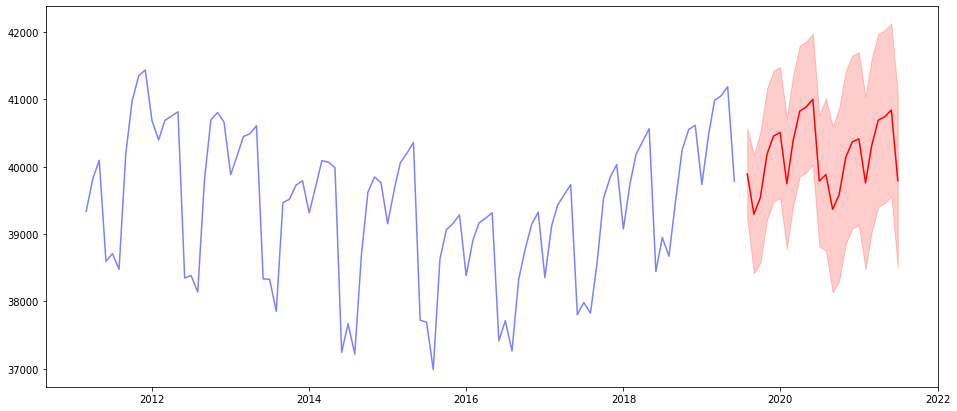

In [21]:
# Plot the series, mean forecast and 95tile prediction "cone"
fig = plt.figure(figsize=(16,7))
ax=plt.axes()
ax.plot(cumulativeDf.index, cumulativeDf.numofempl.values, color = 'blue', alpha = 0.5)
ax.plot(forecast_df.index, forecast_df.forecast.values, color = 'red')
ax.fill_between(forecast_df.index, forecast_df['lower_95_pi'], forecast_df['upper_95_pi'], alpha = 0.2, color = 'red')